<a href="https://colab.research.google.com/github/Jessica-Plante/River-Slope-Analysis-Using-SWOT-Node-Data/blob/main/notebooks/03-TransformationSpectrales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
jupyter: python3
from: markdown+emoji
execute:
  echo: true
  eval: true
  message: false
  warning: false
  keep-ipynb: true
code-overflow: wrap
---

In [1]:
#| echo: false
#| output: false
import matplotlib.pyplot as plt
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams["image.aspect"]= 'equal'
plt.rcParams['figure.dpi'] = 100
import warnings
warnings.filterwarnings('ignore')

# Transformations spectrales {#sec-chap03}

## Préambule

Assurez-vous de lire ce préambule avant d'exécuter le reste du notebook.

### Objectifs

Dans ce chapitre, nous abordons l'exploitation de la dimension spectrale des images satellites. Ce chapitre est aussi disponible sous la forme d'un notebook Python:

[![](https://github.com/sfoucher/TraitementImagesPythonVol1/blob/main/notebooks/images/colab.png?raw=1)](https://colab.research.google.com/github/sfoucher/TraitementImagesPythonVol1/blob/main/notebooks/03-TransformationSpectrales.ipynb)

::::: bloc_objectif
:::: bloc_objectif-header
::: bloc_objectif-icon
:::

**Objectifs d'apprentissage visés dans ce chapitre**
::::

À la fin de ce chapitre, vous devriez être en mesure de :

-   comprendre le principe des indices spectraux;
-   calculer différents indices avec spyndex;
-   analyser le gain en information des indices;
:::::

### Librairies

Les librairies qui vont être explorées dans ce chapitre sont les suivantes:

-   [SciPy](https://scipy.org/)

-   [NumPy](https://numpy.org/)

-   [spyindex](https://github.com/awesome-spectral-indices/spyndex)

-   [Rasterio](https://rasterio.readthedocs.io/en/stable/)

-   [Xarray](https://docs.xarray.dev/en/stable/)

-   [rioxarray](https://corteva.github.io/rioxarray/stable/index.html)

Dans l'environnement Google Colab, seul `rioxarray` doit être installés

In [2]:
#| eval: false
%%capture
!pip install -qU matplotlib rioxarray xrscipy scikit-image pyarrow spyndex

Vérifiez les importations:

In [3]:
import numpy as np
import rioxarray as rxr
from scipy import signal
import xarray as xr
import xrscipy
import matplotlib.pyplot as plt
import spyndex
import rasterio as rio

### Images utilisées

Nous utilisons les images suivantes dans ce chapitre:

In [4]:
#| eval: false
%%capture
import gdown

gdown.download('https://drive.google.com/uc?export=download&confirm=pbef&id=1a6Ypg0g1Oy4AJt9XWKWfnR12NW1XhNg_', output= 'RGBNIR_of_S2A.tif')
gdown.download('https://drive.google.com/uc?export=download&confirm=pbef&id=1a6O3L_abOfU7h94K22At8qtBuLMGErwo', output= 'sentinel2.tif')
gdown.download('https://drive.google.com/uc?export=download&confirm=pbef&id=1_zwCLN-x7XJcNHJCH6Z8upEdUXtVtvs1', output= 'berkeley.jpg')
gdown.download('https://drive.google.com/uc?export=download&confirm=pbef&id=1dM6IVqjba6GHwTLmI7CpX8GP2z5txUq6', output= 'SAR.tif')
gdown.download('https://drive.google.com/uc?export=download&confirm=pbef&id=1aAq7crc_LoaLC3kG3HkQ6Fv5JfG0mswg', output= 'carte.tif')
gdown.download('https://drive.google.com/uc?export=download&confirm=pbef&id=1iCZNYTv0qEZRzPhe22nPdpV4Ks7NsY3b', output= 'ASCIIdata_splib07b_rsSentinel2.zip')
!unzip -q ASCIIdata_splib07b_rsSentinel2.zip

Vérifiez que vous êtes capable de les lire :

In [5]:
#| output: false

with rxr.open_rasterio('berkeley.jpg', mask_and_scale= True) as img_rgb:
    print(img_rgb)
with rxr.open_rasterio('RGBNIR_of_S2A.tif', mask_and_scale= True) as img_rgbnir:
    print(img_rgbnir)
with rxr.open_rasterio('sentinel2.tif', mask_and_scale= True) as img_s2:
    print(img_s2)
with rxr.open_rasterio('carte.tif', mask_and_scale= True) as img_carte:
    print(img_carte)

<xarray.DataArray (band: 3, y: 771, x: 1311)> Size: 12MB
[3032343 values with dtype=float32]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * y            (y) float64 6kB 0.5 1.5 2.5 3.5 4.5 ... 767.5 768.5 769.5 770.5
  * x            (x) float64 10kB 0.5 1.5 2.5 ... 1.308e+03 1.31e+03 1.31e+03
    spatial_ref  int64 8B 0


<xarray.DataArray (band: 4, y: 1926, x: 2074)> Size: 64MB
[15978096 values with dtype=float32]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * y            (y) float64 15kB 5.041e+06 5.041e+06 ... 5.022e+06 5.022e+06
  * x            (x) float64 17kB 7.318e+05 7.318e+05 ... 7.525e+05 7.525e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  subset_RGBNIR_of_S2A_MSIL2A_20240625T153941_N0...
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    AREA_OR_POINT:             Area
<xarray.DataArray (band: 158, y: 963, x: 1037)> Size: 631MB
[157783698 values with dtype=float32]
Coordinates:
  * band         (band) int64 1kB 1 2 3 4 5 6 7 ... 152 153 154 155 156 157 158
  * y            (y) float64 8kB 5.041e+06 5.041e+06 ... 5.022e+06 5.022e+06
  * x            (x) float64 8kB 7.318e+05 7.318e+05 ... 7.525e+05 7.525e+05
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG

## Qu'est ce que l'information spectrale?

L'information spectrale touche à l'exploitation de la dimension spectrale des images (c.à.d le long des bandes spectrales de l'image). La taille de cette dimension spectrale dépend du type de capteurs considéré. Un capteur à très haute résolution spectrale par exemple aura très peu de bandes (4 ou 5). Un capteur multispectral pourra contenir une quinzaine de bande. À l'autre extrême, on trouvera les capteurs hyperspectraux qui peuvent contenir des centaines de bandes spectrales.

![Positions des bandes spectrales pour quelques capteurs ([source](https://landsat.gsfc.nasa.gov/article/sentinel-2a-launches-our-compliments-our-complements/))](images/Landsat.v.Sentinel-2-1.png){fig-align="center" width="6in"}

Pour une surface donnée, la forme des valeurs le long de l'axe spectrale caractérise le type de matériau observé ainsi que son état. On parle souvent alors de signature spectrale. On peut voir celle-ci comme une généralisation de la couleur d'un matériau au delà des bandes visibles du spectre. L'exploitation de ces signatures spectrales est probablement un des principes les plus importants en télédétection qui le distingue de la vison par ordinateur. L'[USGS](https://www.sciencebase.gov/catalog/item/586e8c88e4b0f5ce109fccae) maintient une base de données spectrales acquises en laboratoire [@Kokaly-2017]. On peut observer sur la figure ci-dessous comment la forme et l'amplitude de trois signatures différentes peut changer en fonction du type de surface.

Text(0, 0.5, 'Réflectance')

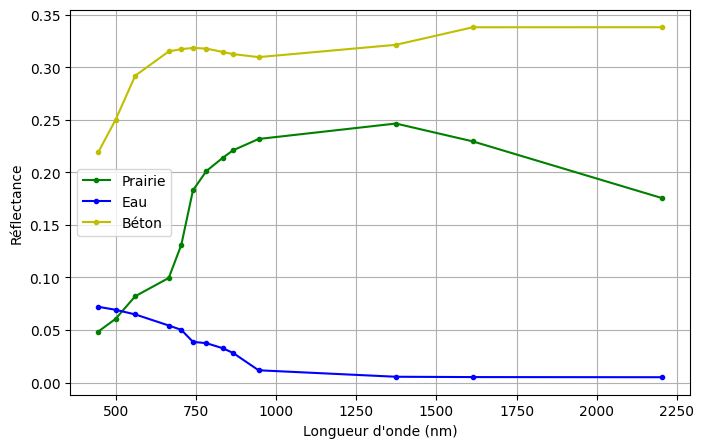

In [6]:
#| echo: false
#| fig-cap: "Exemples de signatures spectrales pour trois surfaces différentes pour les bandes spectrales de Sentinel-2"
HOME= !pwd
with open(f'{HOME[0]}/ASCIIdata_splib07b_rsSentinel2/S07SNTL2_Wavelengths_Sentinel2_(13_bands)_microns.txt','r') as f:
    # Read all lines, skipping the first line
    lines = f.read().split('\n')[1:]
    # Filter out empty or whitespace-only lines before converting to float
    band_pos = [float(s.replace(' ', ''))*1000 for s in lines if s.strip()]

with open('ASCIIdata_splib07b_rsSentinel2/ChapterV_Vegetation/S07SNTL2_Rangeland_C03-004_S08%_G27%_ASDFRa_AREF.txt','r') as f:
    lines = f.read().split('\n')[1:]
    LawnGrass = [float(s.replace(' ', '')) for s in lines if s.strip()]

with open('ASCIIdata_splib07b_rsSentinel2/ChapterL_Liquids/S07SNTL2_Water+Montmor_SWy-2+0.50g-l_ASDFRa_AREF.txt','r') as f:
    lines = f.read().split('\n')[1:]
    Water = [float(s.replace(' ', '')) for s in lines if s.strip()]


with open('ASCIIdata_splib07b_rsSentinel2/ChapterA_ArtificialMaterials/S07SNTL2_Concrete_GDS375_Lt_Gry_Road_ASDFRa_AREF.txt','r') as f:
    lines = f.read().split('\n')[1:]
    Concrete = [float(s.replace(' ', '')) for s in lines if s.strip()]
fig, ax= plt.subplots(figsize = (8,5))
plt.plot(band_pos,LawnGrass, 'g.-')
plt.plot(band_pos,Water, 'b.-')
plt.plot(band_pos,Concrete, 'y.-')
plt.legend(['Prairie','Eau','Béton'])
ax.grid('on')
ax.set_xlabel('Longueur d\'onde (nm)')
ax.set_ylabel('Réflectance')

## Indices spectraux

Il existe une vaste littérature sur les indices spectraux, le choix d'un indice plutôt qu'un autre dépend fortement de l'application visée, nous allons simplement couvrir les principes de base ici. Le principe d'un indice spectral consiste à mettre en valeur certaines caractéristiques saillantes du spectre comme des pentes, des gradients, etc.

La librairie Python [Awesome Spectral Indices](https://awesome-ee-spectral-indices.readthedocs.io/en/latest/) maintient une liste de plus de 200 indices spectraux (radar et optiques). La liste complète est affichable avec la commande suivante:

In [7]:
spyndex.indices

SpectralIndices(['AFRI1600', 'AFRI2100', 'ANDWI', 'ARI', 'ARI2', 'ARVI', 'ATSAVI', 'AVI', 'AWEInsh', 'AWEIsh', 'BAI', 'BAIM', 'BAIS2', 'BCC', 'BI', 'BITM', 'BIXS', 'BLFEI', 'BNDVI', 'BRBA', 'BWDRVI', 'BaI', 'CCI', 'CIG', 'CIRE', 'CRI550', 'CRI700', 'CRSWIR', 'CSI', 'CSIT', 'CVI', 'DBI', 'DBSI', 'DPDD', 'DSI', 'DSWI1', 'DSWI2', 'DSWI3', 'DSWI4', 'DSWI5', 'DVI', 'DVIplus', 'DpRVIHH', 'DpRVIVV', 'EBBI', 'EBI', 'EMBI', 'ENDVI', 'EVI', 'EVI2', 'EVIv', 'ExG', 'ExGR', 'ExR', 'FAI', 'FCVI', 'FDI', 'FWEI', 'GARI', 'GBNDVI', 'GCC', 'GDVI', 'GEMI', 'GLI', 'GM1', 'GM2', 'GNDVI', 'GOSAVI', 'GRNDVI', 'GRVI', 'GSAVI', 'GVMI', 'IAVI', 'IBI', 'IKAW', 'IPVI', 'IRECI', 'IRGBVI', 'LSWI', 'MBI', 'MBWI', 'MCARI', 'MCARI1', 'MCARI2', 'MCARI705', 'MCARIOSAVI', 'MCARIOSAVI705', 'MGRVI', 'MI', 'MIRBI', 'MLSWI26', 'MLSWI27', 'MNDVI', 'MNDWI', 'MNLI', 'MRBVI', 'MSAVI', 'MSI', 'MSR', 'MSR705', 'MTCI', 'MTVI1', 'MTVI2', 'MVI', 'MuWIR', 'NBAI', 'NBLI', 'NBLIOLI', 'NBR', 'NBR2', 'NBRSWIR', 'NBRT1', 'NBRT2', 'NBRT3', 

Le détail d'un indice particulier, par exemple le \`NDVI\`, est aussi affichable:

In [8]:
spyndex.indices["NDVI"]

SpectralIndex(NDVI: Normalized Difference Vegetation Index)
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R']
        * Formula: (N-R)/(N+R)
        * Reference: https://ntrs.nasa.gov/citations/19740022614
        

`spyndex` pré-suppose une nomenclature prédéfinie des [bandes](https://awesome-ee-spectral-indices.readthedocs.io/en/latest/#expressions), on peut voir la correspondance sur le tableau ci-dessous:

In [9]:
spyndex.bands

Bands(['A', 'B', 'G', 'G1', 'N', 'N2', 'R', 'RE1', 'RE2', 'RE3', 'S1', 'S2', 'T', 'T1', 'T2', 'WV', 'Y'])

| Index | Noms | Spyndex | Noms                      |
|-------|------|---------|---------------------------|
| 1     | B01  | A       | Aérosol                   |
| 2     | B02  | B       | Bleu                      |
| 3     | B03  | G       | Vert                      |
| 4     | B04  | R       | Rouge                     |
| 5     | B05  | RE1     | Red edge 1                |
| 6     | B06  | RE1     | Red edge 2                |
| 7     | B07  | RE2     | Red edge 3                |
| 8     | B08  | N       | Proche-infrarouge 1       |
| 9     | B08A | N2      | Proche-infrarouge 2       |
| 10    | B09  | \-      | Vapeur d'eau              |
| 11    | B11  | S1      | Infra-rouge onde courte 1 |
| 12    | B12  | S2      | Infra-rouge onde courte 1 |

: Noms des bandes Sentinel-2

Deux options sont possibles, on peut soit renommer les noms des bandes avec `xarray` ou "mapper" les noms vers les noms appropriés. Regardons les dimensions de notre jeux de données:

In [10]:
img_s2.dims

('band', 'y', 'x')

On peut simplement changer les index (`coords`) de la dimension `band`:

In [11]:
sentinel2_bands= ["A", "B", "G", "R", "RE1", "RE2", "RE3", "N", "N2", "WV", "S1", "S2"]
img_s2 = img_s2.sel(band = list(range(1,13))).assign_coords({'band':sentinel2_bands})
img_s2=img_s2/10000 # normalisation en réflectance

<Axes: title={'center': 'SAVI'}>

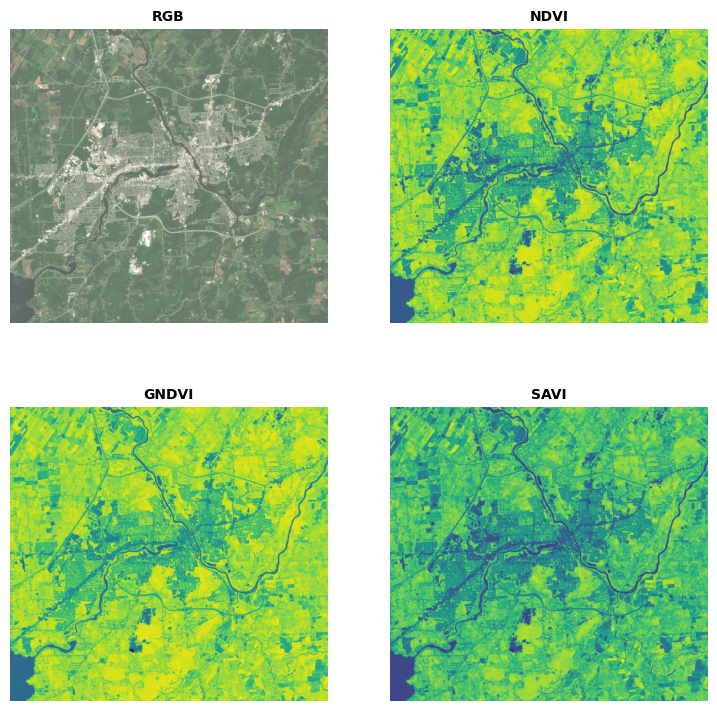

In [12]:
from rasterio import plot
idx = spyndex.computeIndex(
    index = ["NDVI","GNDVI","SAVI"],
    params = {
        "N": img_s2.sel(band = "N"),
        "R": img_s2.sel(band = "R"),
        "G": img_s2.sel(band = "G"),
        "L": 0.5
    }
)

# Plot the indices (and the RGB image for comparison)
fig, ax = plt.subplots(2,2,figsize = (9,9))
[a.axis('off') for a in ax.flatten()]
plot.show(img_s2.sel(band = ["R","G","B"]).data / 0.3,ax = ax[0,0],title = "RGB")
plot.show(idx.sel(index = "NDVI"),ax = ax[0,1],title = "NDVI")
plot.show(idx.sel(index = "GNDVI"),ax = ax[1,0],title = "GNDVI")
plot.show(idx.sel(index = "SAVI"),ax = ax[1,1],title = "SAVI")

On peut vérifier l'utilité des indices en vérifiant leur séparabilité pour certaines classes d'intérêts. Nous reprenons ici l'exemple de la section [@sec-05.02.02] pour vérifier l'utilité des indices `NDVI`, `NDWI` et `NDBI`:

In [13]:
#| eval: false
#| echo: false
#| output: false
#| warning: false
from matplotlib.colors import ListedColormap
import rasterio
import geopandas
from shapely.geometry import Point
import pandas as pd

couleurs_classes= {'NoData': 'black', 'Commercial': 'yellow', 'Nuages': 'lightgrey',
                    'Foret': 'darkgreen', 'Faible_végétation': 'green', 'Sol_nu': 'saddlebrown',
                  'Roche': 'dimgray', 'Route': 'red', 'Urbain': 'orange', 'Eau': 'blue', 'Tourbe': 'salmon', 'Végétation éparse': 'darkgoldenrod', 'Roche avec végétation': 'darkseagreen'}
nom_classes= [*couleurs_classes.keys()]
couleurs_classes= [*couleurs_classes.values()]
cmap_classes = ListedColormap(couleurs_classes)

img_carte= img_carte.squeeze()
class_counts = np.unique(img_carte.data, return_counts=True)

# Liste vide des points échantillonnées
sampled_points = []
class_labels= [] # contient les étiquettes des classes
for class_label in range(1,13): # pour chacune des 12 classes
  # On cherche tous les pixels pour cette étiquette
  class_pixels = np.argwhere(img_carte.data == class_label)

  # On se limite à 100 pixels par classe
  n_samples = min(100, len(class_pixels))

  # On les choisit les positions aléatoirement
  np.random.seed(0) # ceci permet de répliquer le tirage aléatoire
  sampled_indices = np.random.choice(len(class_pixels), n_samples, replace=False)

  # On prends les positions en lignes, colonnes
  sampled_pixels = class_pixels[sampled_indices]

  # On ajoute les points à la liste
  sampled_points.extend(sampled_pixels)
  class_labels.extend(np.array([class_label]*n_samples)[:,np.newaxis])

# Conversion en NumPy array
sampled_points = np.array(sampled_points)
class_labels = np.array(class_labels)
# On peut naviguer les points à l'aide de la géoréférence
transformer = rasterio.transform.AffineTransformer(img_carte.rio.transform())
transform_sampled_points= transformer.xy(sampled_points[:,0], sampled_points[:,1])

points = [Point(xy) for xy in zip(transform_sampled_points[0], transform_sampled_points[1])]
gdf = geopandas.GeoDataFrame(range(1,len(points)+1), geometry=points, crs=img_carte.rio.crs)
coord_list = [(x, y) for x, y in zip(gdf["geometry"].x, gdf["geometry"].y)]
with rasterio.open('sentinel2.tif') as src:
  values = [x[0:13]/10000.0 for x in src.sample(coord_list)]
for b, band in enumerate(sentinel2_bands):
  gdf[band] = [x[b] for x in values]
gdf['class']= class_labels

<Figure size 1500x1500 with 0 Axes>

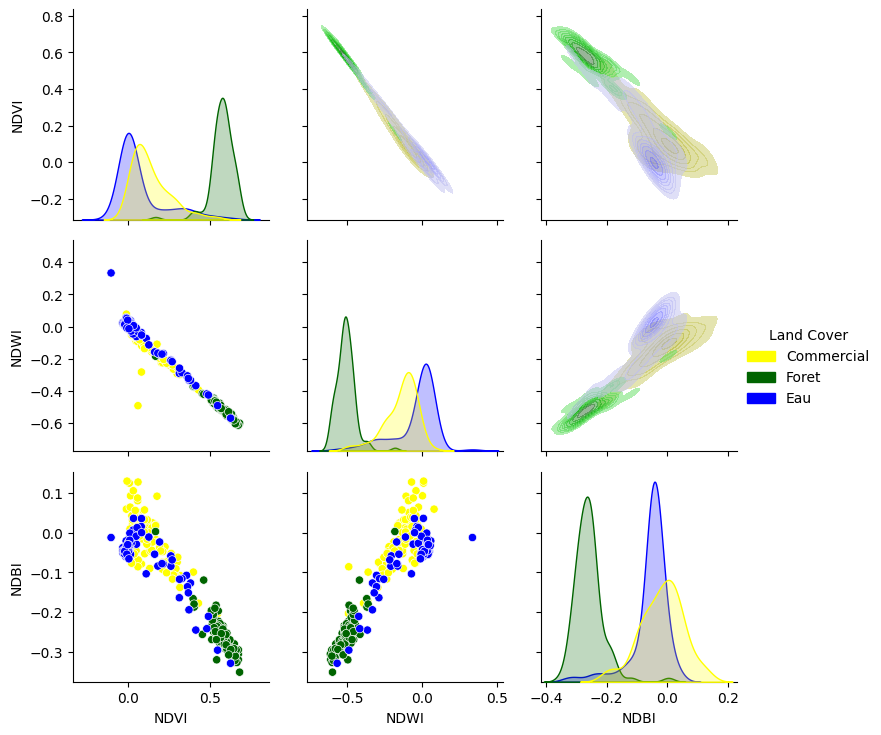

In [14]:
#| eval: false
#| warning: false

import pandas as pd
import seaborn as sns

# On sélectionne trois classes
class_selected= [1,3,9]
df= pd.concat([gdf[gdf['class'] ==c] for c in class_selected], ignore_index=True)

# Compute the desired spectral indices
idx = spyndex.computeIndex(
    index = ["NDVI","NDWI","NDBI"],
    params = {
        "N": df["N"],
        "R": df["R"],
        "G": df["G"],
        "S1": df["S1"]
    }
)
idx["Land Cover"] = [nom_classes[l] for l in df["class"].tolist()] # Add Land Cover to DataFrame
colors= [couleurs_classes[c] for c in class_selected]
# Plot a pairplot to check the indices behaviour
plt.figure(figsize = (15,15))
g = sns.PairGrid(idx,hue = "Land Cover",palette = sns.color_palette(colors))
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot,fill = True,alpha = .5)
g.map_diag(sns.kdeplot,fill = True)
g.add_legend()
plt.show()

![Visualisation des points d'une image Sentinel-2 pour trois classes](https://github.com/sfoucher/TraitementImagesPythonVol1/blob/main/notebooks/images/fig-classes-indices.png?raw=1){fig-align="center"}


<!---
## Réduction de dimension

La réduction de dimension vise à ne retenir que l'information principale d'un jeu de données. L'objectif est parfois d'éliminer le bruit d'un capteur ou de faciliter la visualisation en ne retenant que 3 bandes principales. Le degré d'information est souvent mesuré par la variance d'une bande, c'est à dire son contraste. L'analyse en composante principale vise alors à ranger l'information contenue dans une image en ordre de variance décroissante.

### Analyses en composantes principales

L'analyse en composantes principales (ACP) est probablement la plus employée. En théorie, l'ACP n'est valide seulement que sur des données Gaussiennes c'est à dire que le nuage de points des données a la forme d'une ellipse à N dimensions. Cette ellipse est caractérisée par des directions principales (grand axe versus petit axe). La première composante est celle du grand axe de l'ellipse pour laquelle la donnée présente le maximum de variation. L'ACP est une décomposition linéaire, c'est à dire que les composantes principales sont des sommes pondérées des valeurs originales.
--->

## Quiz


::: {.content-visible when-profile="production"}

Utilisez la version html.
:::


In [15]:
#| echo: false
#| eval: true
from code_complementaire.quizz_functions import Quiz, render_quizz
Chap01Quiz = Quiz("quiz/Chap01.yml", "Chap01")
render_quizz(Chap01Quiz)
#import os
#output_format = os.environ.get("QUARTO_PROFILE")
#print(output_format)

ModuleNotFoundError: No module named 'code_complementaire'